**Addendum: It turns out that the "anomalous" exclusions documented in this blog post can be explained by an unusual procedure:
Iterated exclusions within conditions. Please check out <a href="https://quentinandre.net/post/how-not-to-deal-with-outliers/">
this updated blogpost</a> for more details.**

In [1]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pingouin as pg
import scipy.stats as stats
import seaborn as sns
from IPython.display import HTML, display

# Reading the original data
df_all = pd.read_csv("files/data_blind.csv")
df_no_outliers = df_all.query("Excluded_Outliers == 'No'")

A recent paper in a leading psychology journal reports a pre-registered experiment with significant results: Participants in the "Predicted High" condition have higher scores than participants in the "Predicted Low" condition.

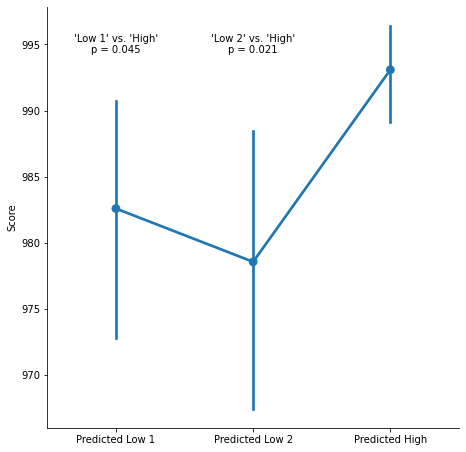

In [2]:
h = df_no_outliers.query("Condition == 'Predicted High'").Score
l1 = df_no_outliers.query("Condition == 'Predicted Low 1'").Score
l2 = df_no_outliers.query("Condition == 'Predicted Low 2'").Score
p1 = stats.ttest_ind(h, l1, equal_var=False).pvalue
p2 = stats.ttest_ind(h, l2, equal_var=False).pvalue
g = sns.catplot(
    y="Score",
    x="Condition",
    data=df_no_outliers,
    height=6.38,
    order=["Predicted Low 1", "Predicted Low 2", "Predicted High"],
    kind="point",
)
g.set_ylabels("Score")
g.set_xlabels("")
g.ax.annotate(f"'Low 1' vs. 'High'\np = {p1:-1.3f}",
              (0, 995), ha="center", va="center")
g.ax.annotate(f"'Low 2' vs. 'High'\np = {p2:.3f}",
              (1, 995), ha="center", va="center");
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig1"))

Those results are obtained after a series of (pre-registered) exclusions. In particular, the authors write in the pre-registration that they will exclude participants whose scores are **'extreme outliers, as identified by boxplot'**.

This description is a bit vague, but those exclusions were visibly helpful: This is what the results look like before excluding the outliers.


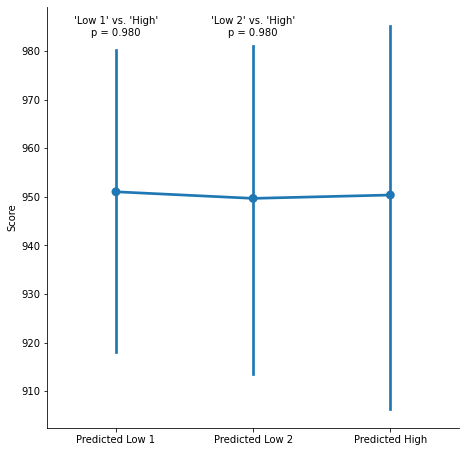

In [3]:
h = df_all.query("Condition == 'Predicted High'").Score
l1 = df_all.query("Condition == 'Predicted Low 1'").Score
l2 = df_all.query("Condition == 'Predicted Low 2'").Score
p1 = stats.ttest_ind(h, l1, equal_var=False).pvalue
p2 = stats.ttest_ind(h, l2, equal_var=False).pvalue


g = sns.catplot(
    y="Score",
    x="Condition",
    data=df_all,
    height=6.38,
    order=["Predicted Low 1", "Predicted Low 2", "Predicted High"],
    kind="point",
)
g.set_xlabels("")
g.ax.annotate(f"'Low 1' vs. 'High'\np = {p1:-1.3f}",
              (0, 985), ha="center", va="center")
g.ax.annotate(f"'Low 2' vs. 'High'\np = {p2:.3f}",
              (1, 985), ha="center", va="center")
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig2"))

Is the paper a bit more precise about those exclusions? Yes! Another study in the paper defines the *extreme outliers* cutoff as *three times the interquartile range below the lower quartile".

$$ x < Q_1 - 3\times IQR$$

The paper also specifies that this threshold will be applied *within each condition* (more on this later). Does the data match this definition?

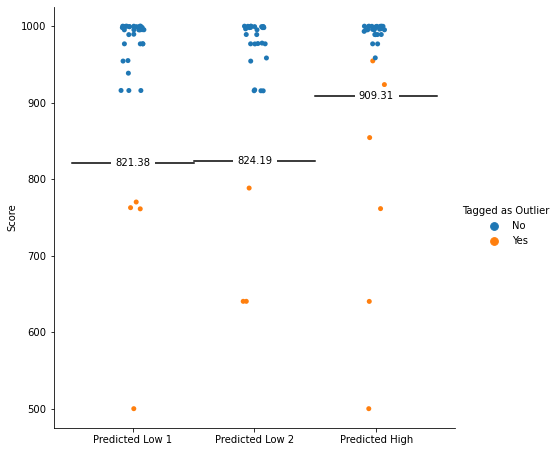

In [4]:
g = sns.catplot(
    y="Score",
    x="Condition",
    hue="Excluded_Outliers",
    order=["Predicted Low 1", "Predicted Low 2", "Predicted High"],
    data=df_all,
    height=6.38,
    legend=False,
)

for c, x in zip(
    ["Predicted Low 1", "Predicted Low 2", "Predicted High"],
    [0, 1, 2]
):
    scores = df_all.query("Condition == @c").Score
    cutoff = scores.quantile(0.25) - 3 * stats.iqr(scores)
    plt.plot([x - 0.5, x + 0.5], [cutoff, cutoff], color="black")
    g.ax.annotate(
        f"{cutoff:.2f}",
        (x, cutoff),
        ha="center",
        va="center",
        bbox=dict(fc="white", ec="white"),
    )
g.add_legend(title="Tagged as Outlier")
g.set_xlabels("")
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig3"))

This graph shows a clear anomaly: Two observations are above the cutoffs defined by the authors, and are still tagged as "outliers" (and therefore excluded from the analysis). Those two observations are the observations in the "Predicted High" condition with the **lowest** score.

Since this condition is predicted to have a higher score than the other two conditions, this might drive the pattern of results. What happens if we properly apply the cutoff instead, and include those two data points back in the sample?

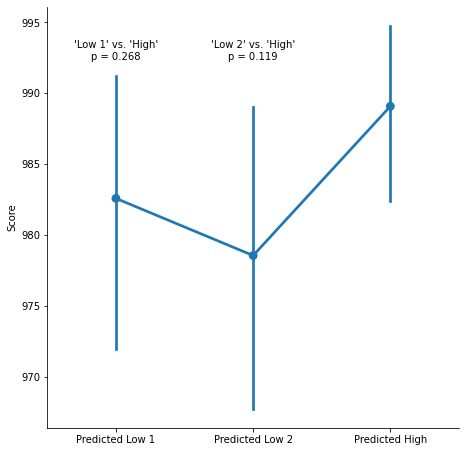

In [5]:
df_correct = df_all.query("Score > 909.31")

h = df_correct.query("Condition == 'Predicted High'").Score
l1 = df_correct.query("Condition == 'Predicted Low 1'").Score
l2 = df_correct.query("Condition == 'Predicted Low 2'").Score
p1 = stats.ttest_ind(h, l1, equal_var=False).pvalue
p2 = stats.ttest_ind(h, l2, equal_var=False).pvalue


g = sns.catplot(
    y="Score",
    x="Condition",
    data=df_correct,
    height=6.38,
    order=["Predicted Low 1", "Predicted Low 2", "Predicted High"],
    kind="point",
)
g.set_xlabels("")
g.ax.annotate(f"'Low 1' vs. 'High'\np = {p1:-1.3f}",
              (0, 993), ha="center", va="center")
g.ax.annotate(f"'Low 2' vs. 'High'\np = {p2:.3f}",
              (1, 993), ha="center", va="center")
fig = plt.gcf()
plt.close()
display(fig, metadata=dict(filename="Fig4"))

After correctly applying the cutoff, we no longer observe significant differences between conditions.

It appears that data points that should not have been considered as outliers were excluded from the analysis.
Unfortunately, this anomalous exclusion appears to make the difference between significant and non-significant differences between conditions.

## But Wait, There's More!

But what if the analysis had correctly included the two "anomalous outliers"?

Unfortunately, **it would still be invalid, because the outliers are excluded within conditions (rather than across the data)!**

When researchers apply a different cutoffs for different conditions, they are implicitly rejecting the null that the conditions are drawn from a common distribution. How can we interpret the results of null-hypothesis tests if we have already assumed that the null was not true when pre-processing the data?

In particular, when the data has small N per condition and is overdispersed (which is true of this paper), ignoring this fact has extremely severe consequences on the false-positive rate.

To illustrate, I ran the following simulation:

1. I created two simulated "conditions" by draw participants at random, without replacement, from the papers' data. I draw 32  observations in each condition (i.e., the average number of participants in each condition).
2. I run three different t-tests on this simulated data (as in the paper, I apply Welch's t-test, but the same results are observed with standards t-tests):
    * A first t-test using the paper's method: I exclude the outliers within each of the two conditions, applying **different cutoffs** to each of the two conditions
    * A second t-test after excluding the outliers, identified by a **common cutoff** across the two conditions (the "Common Cutoff" t-test)
    * A third t-test with **no exclusion** of outliers.
3. I write down the p-value of each of the three t-tests, and repeat this experiment a very large of time (~10,000 times).

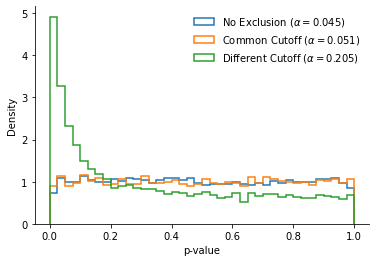

In [6]:
# A few useful functions first

def exclude_extreme_outliers(x):
    """
    A small utility function to exclude *extreme outliers**
    from a vector: Values that are below Q1 - 3*IQR
    """
    iqr = stats.iqr(x)
    low_cutoff = np.percentile(x, 25) - 3 * iqr
    return x[(x > low_cutoff)]


def exclude_extreme_outliers_common(x, y):
    """
    Same function, but applies a common cutoff to two vectors.
    """
    xy = np.concatenate([x, y])
    iqr = stats.iqr(xy)
    low_cutoff = np.percentile(xy, 25) - 3 * iqr
    return (
        x[(x > low_cutoff)],
        y[(y > low_cutoff)],
    )

# The simulated experiment
def compare_data_under_null(data, n=32):
    """
    Compare two vectors of data sampled at random from the authors' data,
    and return the p-values when (1) No outliers are excluded, (2) Outliers
    are excluded based on a common cutoff, and (3) Outliers are excluded using
    a condition-specific cutoff
    """
    xy = np.random.choice(data, n*2, replace=False)
    x, y = xy[:n], xy[n:]
    p = stats.ttest_ind(x, y, equal_var=False).pvalue

    x_common, y_common = exclude_extreme_outliers_common(x, y)
    p_common = stats.ttest_ind(x_common, y_common, equal_var=False).pvalue

    x_diff = exclude_extreme_outliers(x)
    y_diff = exclude_extreme_outliers(y)
    p_diff = stats.ttest_ind(x_diff, y_diff, equal_var=False).pvalue
    return p, p_common, p_diff



# Let's repeat this experiment 10,000 times:
N = 10000
pvals = np.empty(shape=(3, N))
for i in range(N):
    pvals[:, i] = compare_data_under_null(df_all.Score)
pvals_no_excl, pvals_common_cutoff, pvals_diff_cutoffs = pvals

# Now let's visualize the p-values and false-positive rates:
hist_kws = dict(
    bins=np.arange(0, 1.025, 0.025),
    align="mid", density=True,
    histtype="step", lw=1.5
)
alpha_no_excl = (pvals_no_excl < 0.05).mean()
alpha_common = (pvals_common_cutoff < 0.05).mean()
alpha_diff = (pvals_diff_cutoffs < 0.05).mean()
fig, ax = plt.subplots(1)
ax.hist(
    pvals_no_excl,
    **hist_kws,
    label=f"No Exclusion ($\\alpha= {alpha_no_excl:.3f}$)"
)
ax.hist(
    pvals_common_cutoff,
    **hist_kws,
    label=f"Common Cutoff ($\\alpha= {alpha_common:.3f}$)",
)
ax.hist(
    pvals_diff_cutoffs,
    **hist_kws,
    label=f"Different Cutoff ($\\alpha= {alpha_diff:.3f}$)",
)
ax.legend(frameon=False)
ax.set_xlabel("p-value")
ax.set_ylabel("Density")
sns.despine()
plt.close()
display(fig, metadata=dict(filename="Fig5"))

Since the two "conditions" are formed by drawing at random from the pooled data, they should on average do not differ from each other: The p-values reported by the t-tests should be uniformly spread on the interval [0, 1], and should be lower than .05 only 5% of the time.

This is indeed what we see in the "No Exclusion" and "Common Cutoff" conditions, with a nominal $\alpha$ close to .05.

What about the "Different Cutoffs" condition? The distribution of p-values is so right-skewed that the false positive rate is multiplied by **four**.

Why does this happen? Intuitively, it is because applying different cutoffs to different conditions will **amplify** the small differences that are found under the null, and make those differences more extreme. This leads to a massive inflation in Type 1 error.

[Stephen Spiller](https://www.anderson.ucla.edu/faculty-and-research/marketing/faculty/spiller) pointed out on Twitter that this Type I error inflation will also happen if your data is normal: You will underestimate the variance, and therefore overestimate the magnitude of your differences.

The take-away is simple: **Do not apply different cutoffs to different conditions when excluding outliers.**